# First model 

This model will try to predict wether pe is present or not on a single image (grey level)

## Imports

In [9]:
import numpy as np
from balance import *
from model import *

In [10]:
import torch
torch.cuda.empty_cache()

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary

PyTorch version: 1.7.1
GPU found :)


# Load datasets

In [11]:
channel0_dataset = torch.load('datasets/channel0.pt')
channel1_dataset = torch.load('datasets/channel1.pt')
channel2_dataset = torch.load('datasets/channel2.pt')

## Simple CNN from scratch

In [12]:
class ModelV1(nn.Module):
    
    def __init__(self, input_channels):
        """Simple Convnet with 2 convolution layer + pooling, with 2 fully connected at the end"""
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32*62*62 , 120)
        self.fc2 = nn.Linear(120, 1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*62*62) # Flatten
        x = F.relu(self.fc1(x))
        
        # Binary classification
        out = self.sigmoid(self.fc2(x))
        
        return out
    
summary(ModelV1(1).to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             160
         MaxPool2d-2         [-1, 16, 127, 127]               0
            Conv2d-3         [-1, 32, 125, 125]           4,640
         MaxPool2d-4           [-1, 32, 62, 62]               0
            Linear-5                  [-1, 120]      14,761,080
            Linear-6                    [-1, 1]             121
           Sigmoid-7                    [-1, 1]               0
Total params: 14,766,001
Trainable params: 14,766,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 14.60
Params size (MB): 56.33
Estimated Total Size (MB): 71.18
----------------------------------------------------------------


## Split data into train and test

In [13]:
batch_size = 1

train_loader0, test_loader0 = train_test_split(channel0_dataset, ratio=0.2, batch_size=batch_size)
train_loader1, test_loader1 = train_test_split(channel1_dataset, ratio=0.2, batch_size=batch_size)
train_loader2, test_loader2 = train_test_split(channel2_dataset, ratio=0.2, batch_size=batch_size)

## Model Training

In [6]:
model_channel0 = ModelV1(input_channels=1).to(device)
model_channel1 = ModelV1(input_channels=1).to(device)
model_channel2 = ModelV1(input_channels=1).to(device)

In [7]:
num_epoch = 10
criterion = nn.BCELoss()
optimizer0 = optim.Adam(model_channel0.parameters(), lr=0.001)
optimizer1 = optim.Adam(model_channel1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model_channel2.parameters(), lr=0.001)

save_filename0 = './models/model_v1_channel0.h5'
save_filename1 = './models/model_v1_channel1.h5'
save_filename2 = './models/model_v1_channel2.h5'

model_channel0, losses_0 = train(model_channel0, num_epoch, criterion, train_loader0, optimizer0, device, save_filename0)
model_channel1, losses_1 = train(model_channel1, num_epoch, criterion, train_loader1, optimizer1, device, save_filename1)
model_channel2, losses_2 = train(model_channel2, num_epoch, criterion, train_loader2, optimizer2, device, save_filename2)

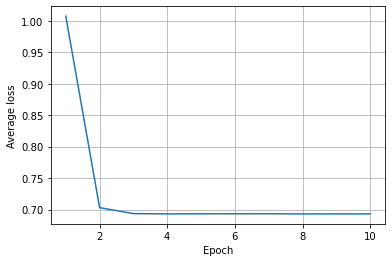

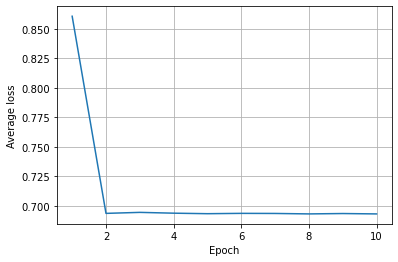

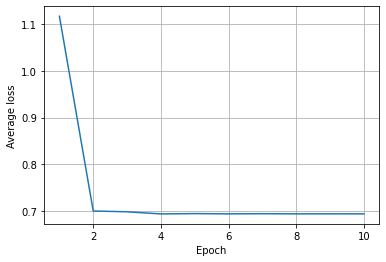

In [8]:
plot_loss(losses_0, num_epoch, len(train_loader0), 'Loss model v1 channel 0.png')
plot_loss(losses_1, num_epoch, len(train_loader1), 'Loss model v1 channel 1.png')
plot_loss(losses_2, num_epoch, len(train_loader2), 'Loss model v1 channel 2.png')

## Test the model

In [14]:
# Load models for evaluation
model_channel0 = ModelV1(input_channels=1)
model_channel0.load_state_dict(torch.load('./models/model_v1_channel0.h5'))
model_channel0.to(device)

model_channel1 = ModelV1(input_channels=1)
model_channel1.load_state_dict(torch.load('./models/model_v1_channel1.h5'))
model_channel1.to(device)

model_channel2 = ModelV1(input_channels=1)
model_channel2.load_state_dict(torch.load('./models/model_v1_channel2.h5'))
model_channel2.to(device)

ModelV1(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=123008, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
acc0, total0 = evaluate(model_channel0, test_loader0, device)
acc1, total1 = evaluate(model_channel1, test_loader1, device)
acc2, total2 = evaluate(model_channel2, test_loader2, device)

In [16]:
print(f'Accuracy of the network on the {total0} test studies (channel 0): {acc0:.2f}')
print(f'Accuracy of the network on the {total1} test studies (channel 1): {acc1:.2f}')
print(f'Accuracy of the network on the {total2} test studies (channel 2): {acc2:.2f}')

Accuracy of the network on the 1254 test studies (channel 0): 50.00
Accuracy of the network on the 1254 test studies (channel 1): 48.64
Accuracy of the network on the 1254 test studies (channel 2): 49.84
